In [38]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [39]:
## Establish a Baseline Performance

In [40]:
### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [41]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("C:/Users/panka/Repositories/Module_14_Challenge_AlgoTrading/Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [42]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


In [43]:
## Step 2: Generate trading signals using short- and long-window SMA values. 

In [44]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [45]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [46]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [47]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

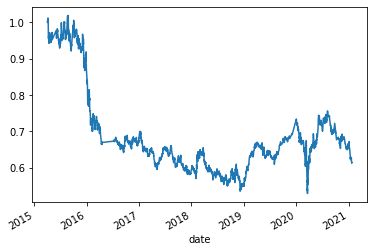

In [48]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [49]:
### Step 3: Split the data into training and testing datasets

In [50]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [51]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [52]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [53]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [54]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [55]:
# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [56]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.0919
2015-07-06 10:45:00,23.9700,25.0682
2015-07-06 14:15:00,23.8475,25.0458
2015-07-06 14:30:00,23.6725,25.0206
2015-07-07 11:30:00,23.4800,24.9951


In [57]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [58]:
### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [59]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [60]:
### Step 5: Review the classification report associated with the `SVC` model predictions

In [61]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



In [62]:
### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”

In [64]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [65]:
### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns

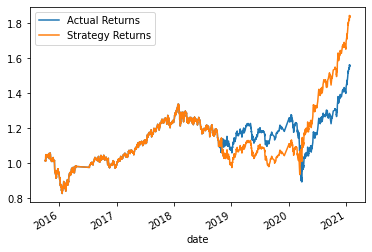

In [89]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Save image to Images folder
plt.savefig(Path("C:/Users/panka/Repositories/Module_14_Challenge_AlgoTrading/Images/svm_strategy_returns.png"))

In [70]:
## Tune the Baseline Trading Algorithm

In [78]:
# Tune the training algorithm by adjusting the size of the training dataset

# Select the start of the training period
training_begin_new = X.index.min()

# Display the training begin date
print(training_begin_new)

2015-04-02 15:00:00


In [79]:
# Select the ending period for the training data with an offset of 6 months
training_end_new = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end_new)

2015-10-02 15:00:00


In [80]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin_new:training_end_new]
y_train = y.loc[training_begin_new:training_end_new]

In [81]:
# Review the X_train DataFrame
X_train.tail()

,SMA_Fast,SMA_Slow
date,,
2015-09-30 14:45:00,21.4800,21.6888
2015-10-02 09:30:00,21.2325,21.6672
2015-10-02 10:30:00,20.9875,21.6465
2015-10-02 11:30:00,20.7775,21.6293
2015-10-02 14:45:00,20.9450,21.6144


In [82]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end_new+DateOffset(hours=1):]
y_test = y.loc[training_end_new+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-10-05 09:45:00,21.42725,21.56409
2015-10-05 11:30:00,21.53225,21.55469
2015-10-05 13:15:00,21.60250,21.54289
2015-10-05 14:30:00,21.66750,21.53089
2015-10-05 14:45:00,21.75250,21.51939


In [83]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [84]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [85]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.02      0.04      1732
         1.0       0.56      0.98      0.71      2211

    accuracy                           0.56      3943
   macro avg       0.50      0.50      0.38      3943
weighted avg       0.51      0.56      0.42      3943



In [86]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-10-05 09:45:00,1.0,0.013532,0.013532
2015-10-05 11:30:00,1.0,0.002302,0.002302
2015-10-05 13:15:00,1.0,-0.000919,-0.000919
2015-10-05 14:30:00,1.0,0.000920,0.000920
2015-10-05 14:45:00,1.0,0.002756,0.002756


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


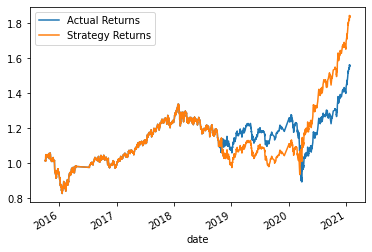

In [88]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Save image to Images folder
plt.savefig(Path("C:/Users/panka/Repositories/Module_14_Challenge_AlgoTrading/Images/svm_strategy_returns_new.png"))

In [90]:
# Answer the following question: What impact resulted from increasing or decreasing the training window?

# By increasing the training window by 3 months (6 months total), the accuracy and recall with the new dataset increased slightly. 
# Overall the returns dint change much

In [91]:
# Tune the trading algorithm by adjusting the SMA input features

In [93]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


In [94]:
# Set the short window and long window
short_window = 50
long_window = 100

# Generate the fast and slow simple moving averages (50 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.4228,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.4314,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.4358,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.4400,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.4456,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,30.40215
2021-01-22 11:30:00,33.35,0.002405,31.2848,30.44445
2021-01-22 13:45:00,33.42,0.002099,31.3480,30.48745
2021-01-22 14:30:00,33.47,0.001496,31.4132,30.53085
2021-01-22 15:45:00,33.44,-0.000896,31.4768,30.57495


In [95]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.4228,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.4314,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.4358,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.4400,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.4456,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,31.2848,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,31.3480,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,31.4132,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,31.4768,30.57495,-1.0


In [96]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.4228,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.4314,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.4358,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.4400,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.4456,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,31.2848,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,31.3480,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,31.4132,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,31.4768,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

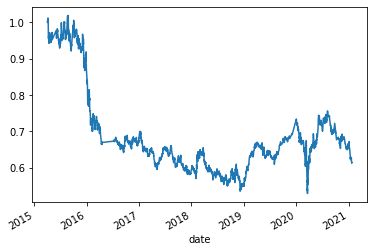

In [97]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [98]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.4228,24.3214
2015-04-02 15:15:00,24.4314,24.3308
2015-04-02 15:30:00,24.4358,24.3360
2015-04-02 15:45:00,24.4400,24.3411
2015-04-06 09:30:00,24.4456,24.3463


In [99]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [100]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [101]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [102]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [103]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.3322,25.0919
2015-07-06 10:45:00,24.3062,25.0682
2015-07-06 14:15:00,24.2834,25.0458
2015-07-06 14:30:00,24.2560,25.0206
2015-07-07 11:30:00,24.2326,24.9951


In [104]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [105]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [106]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      1804
         1.0       0.56      1.00      0.72      2288

    accuracy                           0.56      4092
   macro avg       0.28      0.50      0.36      4092
weighted avg       0.31      0.56      0.40      4092



C:\Users\panka\Anaconda3\envs\dev1\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\panka\Anaconda3\envs\dev1\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\panka\Anaconda3\envs\dev1\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


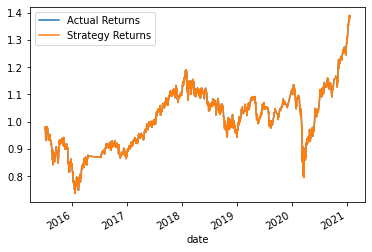

In [108]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Save image to Images folder
plt.savefig(Path("C:/Users/panka/Repositories/Module_14_Challenge_AlgoTrading/Images/svm_strategy_returns_new2.png"))

In [109]:
## Evaluate a New Machine Learning Classifier

In [110]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
lr_model = LogisticRegression()

In [112]:
# Fit the model using the training data
model = lr_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [113]:
# Backtest the new model to evaluate its performance

In [114]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_report = classification_report(y_test, pred)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.24      0.31      1804
         1.0       0.56      0.76      0.64      2288

    accuracy                           0.53      4092
   macro avg       0.50      0.50      0.48      4092
weighted avg       0.50      0.53      0.50      4092



In [115]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
lr_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
lr_predictions_df['Predicted'] = pred

# Add the actual returns to the DataFrame
lr_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
lr_predictions_df['Strategy Returns'] = lr_predictions_df['Actual Returns'] * lr_predictions_df['Predicted']

# Review the DataFrame
display(lr_predictions_df.head())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


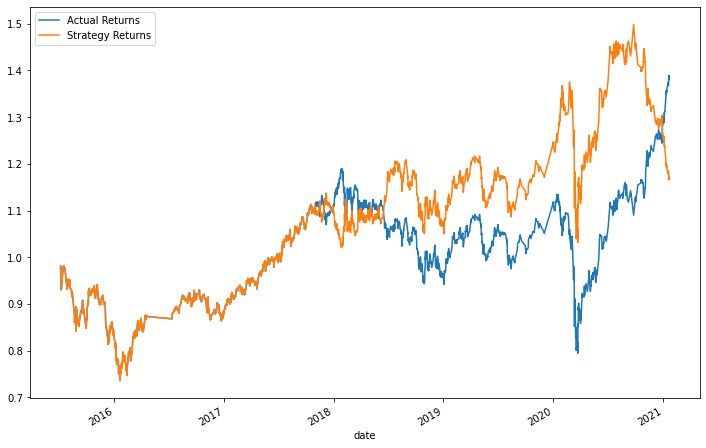

In [116]:
# Plot the actual returns versus the strategy returns
(1 + lr_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(12,8))
# Save image to Images folder
plt.savefig(Path("C:/Users/panka/Repositories/Module_14_Challenge_AlgoTrading/Images/logreg_strategy_returns.png"))

In [117]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [118]:
dt_model = DecisionTreeClassifier()

In [119]:
# Fit the model using the training data
decision_tree_model = dt_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
dt_pred = decision_tree_model.predict(X_test_scaled)

# Review the model's predicted values
dt_pred[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.])

In [120]:
# Use a classification report to evaluate the model using the predictions and testing data
dt_testing_report = classification_report(y_test, dt_pred)

# Print the classification report
print(dt_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.37      0.40      1804
         1.0       0.56      0.62      0.59      2288

    accuracy                           0.51      4092
   macro avg       0.49      0.49      0.49      4092
weighted avg       0.50      0.51      0.50      4092



In [121]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
dt_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
dt_predictions_df['Predicted'] = dt_pred

# Add the actual returns to the DataFrame
dt_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
dt_predictions_df['Strategy Returns'] = dt_predictions_df['Actual Returns'] * dt_pred

# Review the DataFrame
display(dt_predictions_df.head())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


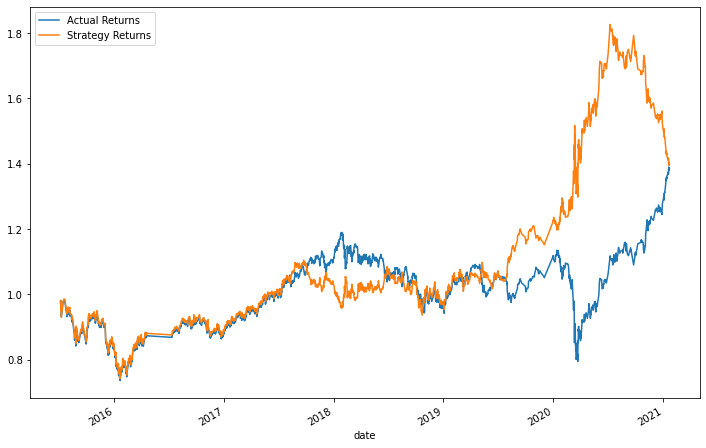

In [123]:
(1 + dt_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(12,8))
# Save image to Images folder
plt.savefig(Path("C:/Users/panka/Repositories/Module_14_Challenge_ML_AlogTrading/Images/dt_strategy_returns.png"))